## This notebook is for testing the SDK before using any scripts for data retrieval / live feed
- Make sure you have the .env file with the corrent variable names listed below before running the code

In [18]:
# Authentication for streaming data
from neurosity import NeurositySDK
from dotenv import load_dotenv
import os

load_dotenv()

neurosity = NeurositySDK({
    "device_id": os.getenv("NEUROSITY_DEVICE_ID")
})

neurosity.login({
    "email": os.getenv("NEUROSITY_EMAIL"),
    "password": os.getenv("NEUROSITY_PASSWORD")
})

In [19]:
# checking the info from the SDK
info = neurosity.get_info()
print(info)

OrderedDict({'channelNames': ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5'], 'channels': 8, 'deviceId': 'e425ea92bcd7bdae65a5c2b07322433d', 'deviceNickname': 'Emulator-E42', 'emulator': True, 'manufacturer': 'Neurosity, Inc', 'model': 'Emulator 2', 'modelName': 'Emulator', 'modelVersion': '2', 'osVersion': '14.5.0', 'samplingRate': 250})


# Raw Brainwaves Data

In [20]:
# Retrieving raw brainwaves and storing 1 epoch
import time
sample = 0

def callback(data):
    global sample
    sample = data
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(1)

unsubscribe()

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# What one epoch looks like
# print(sample)

# Storing & Visualizing 
channels = ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5']
data = np.array(sample['data'])  
print(data)
print(data.shape)
print(sample['info'])

[[-1.09066499e+01 -7.08309718e-01 -2.18677388e-02 -8.14974527e+00
  -1.78919434e+01 -2.01086487e+01 -1.31287237e+01 -1.65213396e+00
   9.65353117e+00  1.54656879e+01  1.21134417e+01  2.19082181e+00
  -7.86191531e+00 -1.26069604e+01 -1.05162830e+01 -5.27841547e+00
  -1.90104576e+00 -3.08747241e+00 -7.51897243e+00 -1.06365539e+01
  -1.18073920e+01 -1.22035101e+01 -9.16114364e+00 -1.80065501e+00
   7.21586627e+00]
 [-3.09554123e-02  1.01071491e+01  2.02910626e+01  2.69425653e+01
   2.48633990e+01  1.33726663e+01 -4.73519012e+00 -2.29254741e+01
  -3.21152620e+01 -2.79045632e+01 -1.28185022e+01  6.72469966e+00
   2.21109374e+01  2.50753296e+01  1.31270093e+01 -7.33353710e+00
  -2.49135616e+01 -2.97020589e+01 -2.00222076e+01 -4.64182564e+00
   6.92978774e+00  1.18812826e+01  1.25685086e+01  1.32387368e+01
   1.47609414e+01]
 [ 7.72061836e-01  1.20326504e+01  2.37496427e+01  3.28472755e+01
   3.61674066e+01  3.31196636e+01  2.26340488e+01  7.90963195e+00
  -1.76622819e+00 -6.98124012e-01  9.8

### Epoch Structure
-  the data is recieved as 8 rows, with each row being a channel, and each column being 1 timestamp with the duration between each other depending on the`samplingRate` attribute. 
    E.g. `samplingRate = 250` means 250 samples per second, each sample being 4 ms, and each epoch being 100 ms
- The values themselves range from -40 to +32 microvolts

In [22]:
# Accumilating 5 seconds worth of epochs
data = np.zeros((8,1))
def callback(new):
    new = np.array(new['data'])
    global data
    data = np.concatenate((data,new), axis=1)
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(5)

unsubscribe()
print(data)
print(data.shape)

[[  0.          26.93041961  26.47920961 ...  -0.30140499   6.91821643
    8.70879487]
 [  0.         -14.02332921  -4.7116852  ...  35.58392964  23.47895181
    8.34124709]
 [  0.          -0.72594954  -4.22232291 ...  -2.62696599  -5.36552366
   -1.82144072]
 ...
 [  0.         -19.53170511 -16.01938526 ...  15.50004352  10.12362898
   11.91120811]
 [  0.          19.09823486  21.05497799 ...  17.35976995  11.9776521
    1.46989828]
 [  0.          -9.82853032 -13.68389866 ...  -3.2040537   -5.96780417
   -5.83752745]]
(8, 1101)


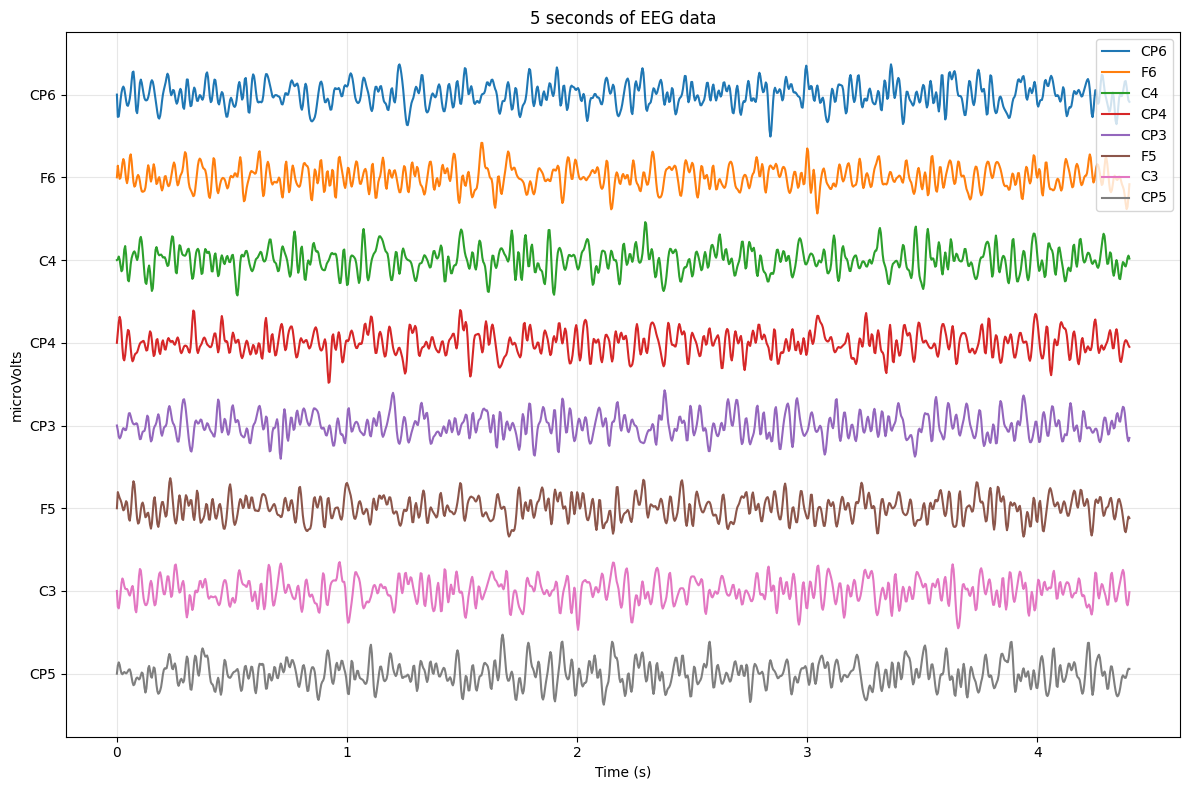

In [23]:
# Visualizing the 5 second window
n_channels, n_samples = data.shape
time = np.arange(n_samples) / 250  # assume 250 Hz sampling rate (adjust!)

plt.figure(figsize=(12, 8))

# Plot each channel with vertical offsets so they don’t overlap
offset = 100  # adjust spacing between signals
for i in range(n_channels):
    plt.plot(time, data[i] + i * offset, label=channels[i])

plt.yticks([i * offset for i in range(n_channels)], channels)
plt.gca().invert_yaxis()

plt.title("5 seconds of EEG data")
plt.xlabel("Time (s)")
plt.ylabel("microVolts")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

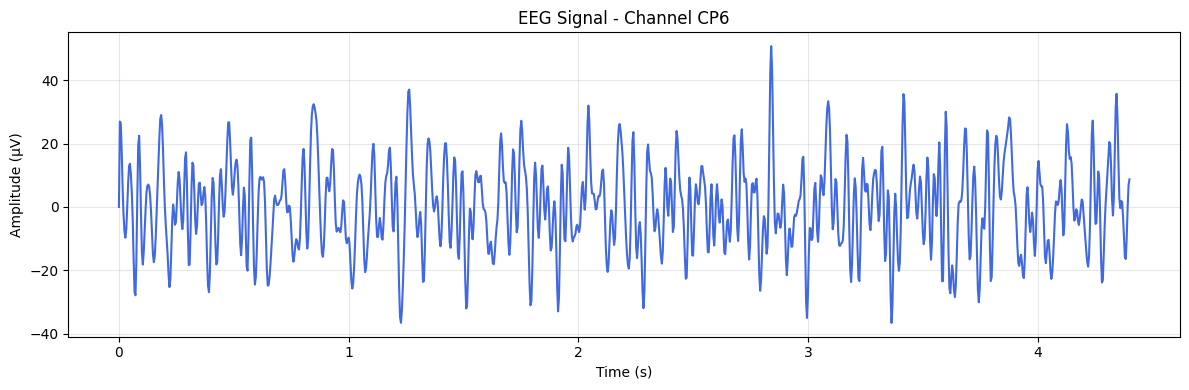

In [24]:
# Visualization for individual channels (e.g. "CP6")
channel_idx = channels.index("CP6")
channel_data = data[channel_idx]

# Sampling rate (adjust to your device)
fs = 250  
time = np.arange(channel_data.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(time, channel_data, color="royalblue")
plt.title(f"EEG Signal - Channel {channels[channel_idx]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Absolute Power

In [ ]:
# Retrieve Absolute Power (AP) brainwaves
import time

ap_sample = None

def ap_callback(data):
    global ap_sample
    ap_sample = data
    print("Absolute Power Update:", data)

# To subscribe to absolute power stream
unsubscribe_ap = neurosity.brainwaves_power_by_band(ap_callback)

# Run for a few seconds
time.sleep(5)

# Stop the subscription
unsubscribe_ap()

print(f"Final Absolute Power Sample: {ap_sample}")

dict_keys(['alpha', 'beta', 'delta', 'gamma', 'theta'])
Absolute Power Update: {'data': {'alpha': [3.519934037176192, 6.414945353561652, 2.570264475555962, 1.6253812282005324, 2.526457311568622, 2.7309367970907217, 4.980616333321469, 3.807206287091063], 'beta': [3.2002844317621815, 3.4018989864498788, 2.465370929482114, 2.440774687142735, 3.7849827673655434, 3.025791575946213, 2.7852659308366854, 2.8576268711688946], 'delta': [0.9044544921297188, 1.7832396423569525, 2.2904003272549245, 2.5758956312276, 1.6530047817470228, 2.342572956928726, 2.0972091479337363, 1.1973304855293665], 'gamma': [0.4605291774840341, 0.6291067526191049, 0.3964932178239643, 0.8426119481087294, 0.5474386731318769, 0.5078751614621837, 0.4545299017169156, 1.056602852854637], 'theta': [0.8474661867509516, 2.3188365895449405, 2.358733598197524, 2.753097627464901, 1.6555759019236302, 2.1297537040970873, 2.2361645299251007, 0.8294931882063397]}, 'label': 'powerByBand'}
dict_keys(['alpha', 'beta', 'delta', 'gamma', 't

In [26]:

print(ap_sample['data'])


{'alpha': [4.011093064298308, 3.6926423501168935, 3.07814383058232, 3.2782289844048216, 3.544504783111023, 1.842802779887948, 3.1906543407327184, 2.773611387713011], 'beta': [3.0388570838227786, 2.2461168083444734, 4.19809738931019, 2.953701845206154, 2.7346965925854425, 2.5629655628139565, 2.9712119162099726, 3.3210150080713614], 'delta': [1.5250813001351375, 2.383479171751781, 3.8793730260955592, 2.8323516579884744, 3.609319523710857, 1.8166572274324282, 2.3720073586931276, 2.190032624675922], 'gamma': [0.9630733498389179, 0.8014410191767402, 0.6085782534537321, 0.667693936019985, 0.7708510088573737, 0.6355176447181786, 0.7525375105817843, 0.4872651718606803], 'theta': [2.61790222545388, 3.3321273593871172, 2.4627876721532287, 4.4334499784720025, 4.737942132844147, 3.5486221975679513, 2.6923034463262647, 2.7239322698796142]}


# Calm/Focus Data

## Neurosity.calm() quick explanation:

neurosity.calm() streams a probability (0–1) that represents how calm the user is, based on EEG signals.

Difference from raw/absolute power:
Instead of giving you raw brainwave amplitudes (e.g. alpha, beta, gamma), it already applies Neurosity’s built-in model to estimate calmness.

A possible use case that we can use: 
We may define relaxed via low beta & high alpha, for example.

In [27]:
# Retrieve Focus/Calm Probability for 5 seconds
import time

def callback(data):
    print("Probability:", data)

# subscribing to focus and calm streams
focus_unsubscribe = neurosity.focus(callback)
calm_unsubscribe = neurosity.calm(callback)
# Run for a few seconds
time.sleep(5)

# Stop the subscription
focus_unsubscribe()
calm_unsubscribe()
print(f"Final Focus Sample: {sample}")

Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5434675247618194, 'timestamp': 1756203171477}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.34352445064584813, 'timestamp': 1756203172120}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5307588390387801, 'timestamp': 1756203172536}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.3466529919894334, 'timestamp': 1756203173194}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5220878963301178, 'timestamp': 1756203173625}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.38661029455450435, 'timestamp': 1756203174296}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.554175210751635, 'timestamp': 1756203174728}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.2091933178366254, 'timestamp': 1756203175399}
Probability: {'label': 'focus', 'metric': 'awareness', 'pro

In [30]:
# Test out callback function for data retrieval
focusList = []
def callback_focus(data):
    global focusList
    focusList.append([data['timestamp'], {data['label']: data['probability']}])

f_unsubscribe = neurosity.focus(callback_focus)
time.sleep(3)
f_unsubscribe()

print(focusList)

[[1756203223875, {'focus': 0.5311104333431232}], [1756203223875, {'focus': 0.5311104333431232}], [1756203224979, {'focus': 0.5564210286773887}], [1756203224979, {'focus': 0.5564210286773887}], [1756203226073, {'focus': 0.514667973232657}], [1756203226073, {'focus': 0.514667973232657}]]
